https://drive.google.com/file/d/1zHwczZ7SQj79kD8ZjvhUg4ZkPrVRL82S/view?usp=sharing

In [1]:
! gdown 1zHwczZ7SQj79kD8ZjvhUg4ZkPrVRL82S

Downloading...
From: https://drive.google.com/uc?id=1zHwczZ7SQj79kD8ZjvhUg4ZkPrVRL82S
To: /content/airlines_flights_data.csv
100% 24.9M/24.9M [00:00<00:00, 38.8MB/s]


In [1]:
! pip install catboost
! pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 700.2 kB/s  0:02:06 eta 0:00:010:00:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [catboost]━━ 1/2 [catboost]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 4.3 MB/s  0:00:005.4 MB/s eta 0:00:01:01


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
def adjusted_r2(y_true, y_pred, X):

    n = len(y_true)        # number of samples
    p = X.shape[1]         # number of features
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adj_r2

In [2]:
df = pd.read_csv('airlines_flights_data.csv')


In [3]:
df = df.drop(['index'],axis=1)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df['flight'] = df.flight.str.split('-').str[0]
df.flight = df.flight.replace({'6.00E':'6E','0.00E+00':'6E'})

In [5]:
df['departure_time'].value_counts()


departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [6]:
df[['departure_time','duration']]

,departure_time,duration
0,Evening,2.17
1,Early_Morning,2.33
2,Early_Morning,2.17
3,Morning,2.25
4,Morning,2.33
...,...,...
300148,Morning,10.08
300149,Afternoon,10.42
300150,Early_Morning,13.83
300151,Early_Morning,10.00


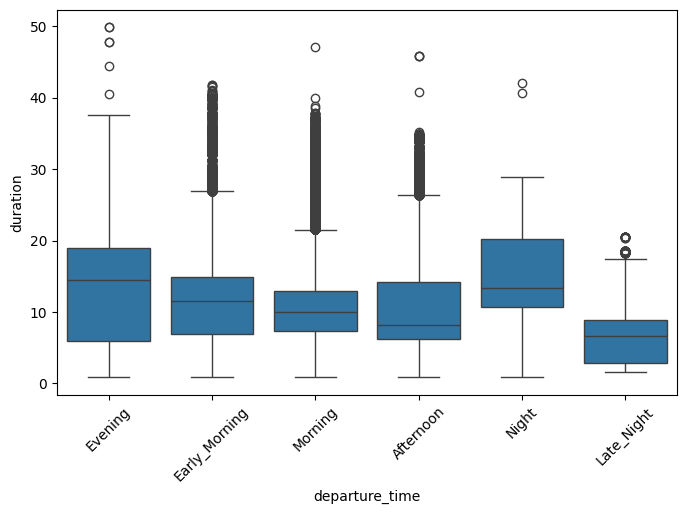

In [7]:
# boxplot relationship
plt.figure(figsize=(8,5))
sns.boxplot(x='departure_time', y='duration', data=df)
plt.xticks(rotation=45)
plt.show()

In [8]:
filtered = df[(df["departure_time"].isin(["Morning", "Early_Morning"]) & (df["arrival_time"].isin(["Morning", "Early_Morning"])))]
filtered

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
1,SpiceJet,SG,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
4,Vistara,UK,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
6,Vistara,UK,Delhi,Morning,zero,Morning,Mumbai,Economy,2.08,1,6060
8,GO_FIRST,G8,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.17,1,5954
...,...,...,...,...,...,...,...,...,...,...,...
300122,Vistara,UK,Chennai,Morning,one,Early_Morning,Hyderabad,Business,22.08,49,41064
300125,Vistara,UK,Chennai,Early_Morning,one,Early_Morning,Hyderabad,Business,24.83,49,41064
300138,Vistara,UK,Chennai,Early_Morning,one,Morning,Hyderabad,Business,26.33,49,51457
300145,Air_India,AI,Chennai,Morning,one,Morning,Hyderabad,Business,23.08,49,51345


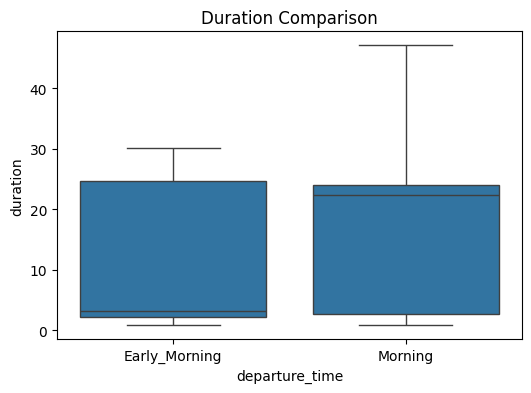

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(x="departure_time", y="duration", data=filtered)
plt.title("Duration Comparison")
plt.show()


In [10]:
# df["is_morning"] = df["departure_time"].isin(["Morning","Early_Morning"]).astype(int)
# df["is_evening"] = df["departure_time"].isin(["Evening","Night"]).astype(int)



In [11]:
df.groupby("departure_time")["duration"].mean()


departure_time
Afternoon        10.757008
Early_Morning    11.587945
Evening          13.642493
Late_Night        7.320383
Morning          11.303808
Night            14.123963
Name: duration, dtype: float64

In [12]:
df['stops'].value_counts()

stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

In [13]:
df["stops"] = df["stops"].map({
    "zero": 0,
    "one": 1,
    "two_or_more": 2
})

# df["has_stop"] = (df["num_stops"] > 0).astype(int)
# df["multiple_stops"] = (df["num_stops"] > 1).astype(int)


In [14]:
df['duration_hours'] = df['duration'].astype(int)
df['duration_minutes'] = ((df['duration'] - df['duration_hours']) * 60).round().astype(int)

In [15]:
df.drop(['duration'],axis=1,inplace=True)


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   airline           300153 non-null  object
 1   flight            300153 non-null  object
 2   source_city       300153 non-null  object
 3   departure_time    300153 non-null  object
 4   stops             300153 non-null  int64 
 5   arrival_time      300153 non-null  object
 6   destination_city  300153 non-null  object
 7   class             300153 non-null  object
 8   days_left         300153 non-null  int64 
 9   price             300153 non-null  int64 
 10  duration_hours    300153 non-null  int64 
 11  duration_minutes  300153 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 27.5+ MB


In [17]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,days_left,price,duration_hours,duration_minutes
0,SpiceJet,SG,Delhi,Evening,0,Night,Mumbai,Economy,1,5953,2,10
1,SpiceJet,SG,Delhi,Early_Morning,0,Morning,Mumbai,Economy,1,5953,2,20
2,AirAsia,I5,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,1,5956,2,10
3,Vistara,UK,Delhi,Morning,0,Afternoon,Mumbai,Economy,1,5955,2,15
4,Vistara,UK,Delhi,Morning,0,Morning,Mumbai,Economy,1,5955,2,20


In [18]:
df['class'].value_counts()

class
Economy     206666
Business     93487
Name: count, dtype: int64

In [19]:
df["class"] = df["class"].map({"Economy":0, "Business":1})


In [20]:
df['source_city'].value_counts()

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

In [21]:
df["flight"].value_counts(normalize=True)

flight
UK    0.425979
AI    0.269503
6E    0.143660
G8    0.077204
I5    0.053633
SG    0.030021
Name: proportion, dtype: float64

In [22]:
df = pd.get_dummies(df, columns=["destination_city"], drop_first=True)
df = pd.get_dummies(df, columns=["source_city"], drop_first=True)
df = pd.get_dummies(df, columns=["departure_time"], drop_first=True)
df = pd.get_dummies(df, columns=["arrival_time"], drop_first=True)
df = pd.get_dummies(df, columns=["airline"], drop_first=True)

# df = pd.get_dummies(df, columns=["flight"], drop_first=True)
# Example for flight column (high cardinality)
freq = df["flight"].value_counts(normalize=True)
df["flight_freq"] = df["flight"].map(freq)
df.drop(columns="flight", inplace=True)


In [23]:
df.head()

,stops,class,days_left,price,duration_hours,duration_minutes,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_freq
0,0,0,1,5953,2,10,False,False,False,False,...,False,False,False,True,False,False,False,True,False,0.030021
1,0,0,1,5953,2,20,False,False,False,False,...,False,False,True,False,False,False,False,True,False,0.030021
2,0,0,1,5956,2,10,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.053633
3,0,0,1,5955,2,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.425979
4,0,0,1,5955,2,20,False,False,False,False,...,False,False,True,False,False,False,False,False,True,0.425979


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   stops                         300153 non-null  int64  
 1   class                         300153 non-null  int64  
 2   days_left                     300153 non-null  int64  
 3   price                         300153 non-null  int64  
 4   duration_hours                300153 non-null  int64  
 5   duration_minutes              300153 non-null  int64  
 6   destination_city_Chennai      300153 non-null  bool   
 7   destination_city_Delhi        300153 non-null  bool   
 8   destination_city_Hyderabad    300153 non-null  bool   
 9   destination_city_Kolkata      300153 non-null  bool   
 10  destination_city_Mumbai       300153 non-null  bool   
 11  source_city_Chennai           300153 non-null  bool   
 12  source_city_Delhi             300153 non-nul

In [25]:
x = df.drop('price',axis=1)
y = df.price
y = np.log(y)

<Axes: xlabel='price', ylabel='Count'>

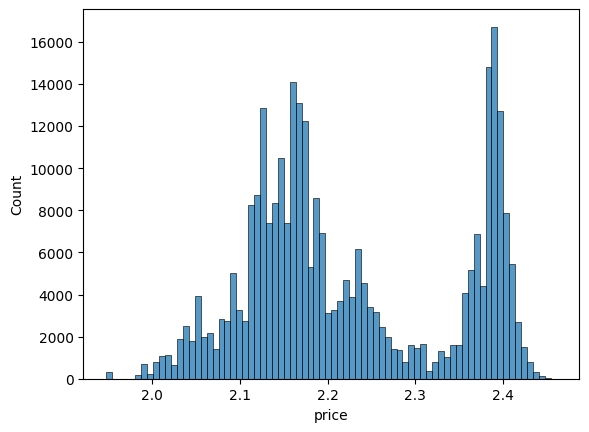

In [26]:
sns.histplot(np.log(y))

<Axes: ylabel='price'>

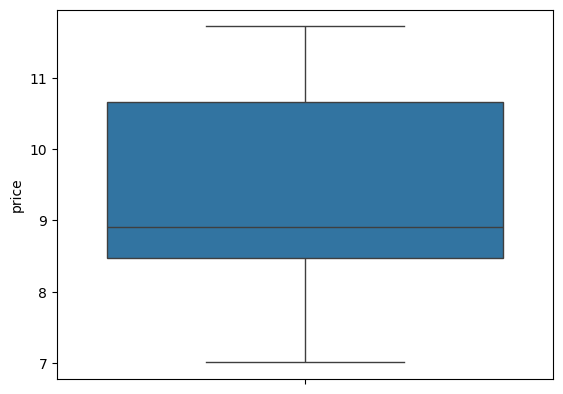

In [27]:
sns.boxplot(y)

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True)

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [30]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=3000,random_state=42),
    # "Decision Tree": DecisionTreeRegressor(random_state=42),
    # "Gradient Boosting": GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05, random_state=42),
    # "AdaBoost Regressor": AdaBoostRegressor(learning_rate=0.05, random_state=42),
    # "XGBoost": XGBRegressor(n_estimators=3000,learning_rate=0.05, random_state=42),
    # "LightGBM": lgb.LGBMRegressor(n_estimators=3000,learning_rate=0.05, random_state=42),
    # "CatBoost": CatBoostRegressor(n_estimators=3000,iterations=500, learning_rate=0.05, verbose=0, random_state=42)
}

In [ ]:
results = []

for name, model in models.items():
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    r2 = r2_score(ytest, preds)
    mae = mean_absolute_error(ytest, preds)
    rmse = np.sqrt(mean_squared_error(ytest, preds))
    print(f"Best {name} n_estimators: {model.best_iteration}")

    results.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
def plot_feature_importance(model, X_train, top_n=20):
    if hasattr(model, "feature_importances_"):
        importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values(by='Importance', ascending=False).head(top_n)

        plt.figure(figsize=(10,6))
        sns.barplot(x='Importance', y='Feature', data=importance)
        plt.title(f'Top {top_n} Feature Importance - {type(model).__name__}')
        plt.show()

# Example: top 20 features for RandomForest
plot_feature_importance(models["Random Forest"], xtrain)

In [ ]:
print(f"Best {name} n_estimators: {model.get_best_iteration()}")

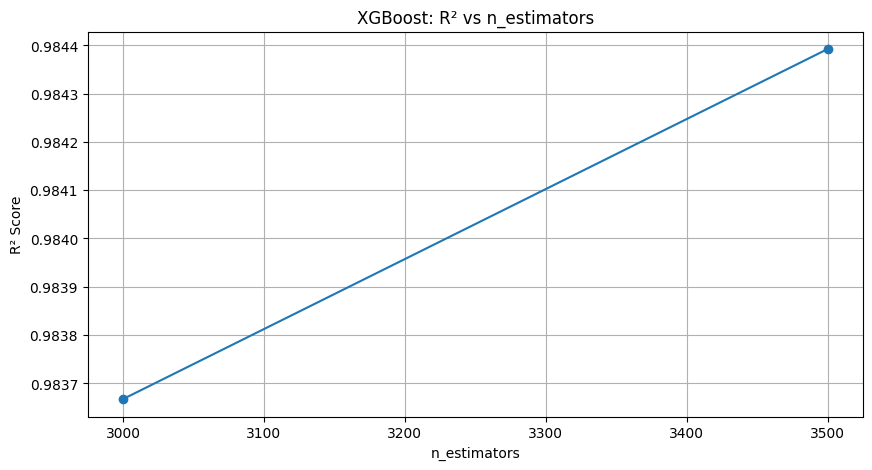

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# Define range of n_estimators to test
# n_estimators_range = [50, 100, 200, 300, 500, 700, 1000, 1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,4000,5000]

n_estimators_range = [2500,2600,2700,2800,2900,3000,4000,5000]

r2_scores = []

# Loop over n_estimators
for n in n_estimators_range:
    model = XGBRegressor(n_estimators=n, learning_rate=0.05, random_state=42)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    r2 = r2_score(ytest, preds)
    r2_scores.append(r2)

# Plot
plt.figure(figsize=(10,5))
plt.plot(n_estimators_range, r2_scores, marker='o')
plt.xlabel("n_estimators")
plt.ylabel("R² Score")
plt.title("XGBoost: R² vs n_estimators")
plt.grid(True)
plt.show()


In [ ]:
print(f"Best n_estimators: {model.get_best_iteration()}")

In [ ]:
r2_scores

[0.9836671948432922, 0.984392523765564]

In [ ]:
r2_scores

[0.9496771693229675,
 0.9612488150596619,
 0.9663226008415222,
 0.9690524935722351,
 0.9730657935142517,
 0.9754763245582581,
 0.9777366518974304,
 0.9802830815315247,
 0.980551540851593,
 0.9809075593948364,
 0.9812644720077515,
 0.9815531373023987,
 0.981850802898407,
 0.9820104837417603,
 0.9823066592216492,
 0.9824877977371216,
 0.9827063083648682,
 0.98287433385849,
 0.9830775856971741,
 0.9832801818847656,
 0.9834077954292297,
 0.9835187196731567,
 0.9836671948432922]

In [ ]:
! pip install optuna

In [ ]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 3000, 5000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42
    }

    model = XGBRegressor(**params, n_jobs=-1)

    # 3-fold cross-validation R²
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="r2").mean()

    return score  # Optuna maximizes R²


study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=50)  # Increase n_trials for more precise tuning

print("Best R²:", study.best_value)
print("Best Hyperparameters:", study.best_params)


best_xgb = XGBRegressor(**study.best_params, n_jobs=-1)
best_xgb.fit(X_train, y_train)


y_pred = best_xgb.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")


[I 2026-02-19 16:36:46,913] A new study created in memory with name: no-name-686b5a33-0c1f-49d9-af7e-beebde9256d8


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12,8))
plot_importance(best_xgb, max_num_features=20)
plt.show()
